In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
import seaborn as sns

##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
6505,00001745_000.png,Consolidation|Infiltration,0,1745,53,M,AP,3056,2544,0.139,0.139,NaN
66148,00016357_001.png,No Finding,1,16357,49,M,PA,2992,2991,0.143,0.143,NaN
34692,00009138_036.png,No Finding,36,9138,69,M,AP,2500,2048,0.168,0.168,NaN


In [3]:
!ls /data

ARXIV_V5_CHESTXRAY.pdf	images_002  images_007	images_012
BBox_List_2017.csv	images_003  images_008	LOG_CHESTXRAY.pdf
Data_Entry_2017.csv	images_004  images_009	README_CHESTXRAY.pdf
FAQ_CHESTXRAY.pdf	images_005  images_010	test_list.txt
images_001		images_006  images_011	train_val_list.txt


In [4]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [5]:
# statistics
all_xray_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


In [6]:
# drop the Unnamed: 11 column
all_xray_df = all_xray_df.drop(columns=['Unnamed: 11'])

In [7]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].apply(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
all_xray_df['Class'] = all_xray_df['Pneumonia'].apply(lambda x: 'Pneumonia' if x==1 else "Non-pneumonia")
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Class
62856,00015541_000.png,No Finding,0,15541,45,F,PA,2048,2500,0.168,...,0,0,0,0,1,0,0,0,0,Non-pneumonia
62162,00015381_000.png,No Finding,0,15381,30,F,PA,2354,2985,0.143,...,0,0,0,0,1,0,0,0,0,Non-pneumonia
13719,00003535_007.png,No Finding,7,3535,19,F,AP,3056,2544,0.139,...,0,0,0,0,1,0,0,0,0,Non-pneumonia


In [8]:
for label in all_labels:
    all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if label in finding else 0)
all_xray_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Class
10826,00002811_000.png,No Finding,0,2811,8,M,PA,2048,2500,0.171000,...,0,0,0,0,1,0,0,0,0,Non-pneumonia
109847,00029880_005.png,No Finding,5,29880,67,M,PA,2020,2021,0.194311,...,0,0,0,0,1,0,0,0,0,Non-pneumonia
77014,00018921_030.png,No Finding,30,18921,43,F,AP,2500,2048,0.168000,...,0,0,0,0,1,0,0,0,0,Non-pneumonia
25975,00006827_007.png,Mass,7,6827,45,F,AP,2500,2048,0.171000,...,0,0,0,1,0,0,0,0,0,Non-pneumonia
60947,00015041_014.png,No Finding,14,15041,33,M,AP,2500,2048,0.168000,...,0,0,0,0,1,0,0,0,0,Non-pneumonia


In [9]:
all_xray_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Atelectasis,Cardiomegaly,Consolidation,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,...,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,0.103095,0.024759,0.041625,...,0.022440,0.015037,0.002025,0.177435,0.051570,0.538361,0.056466,0.030191,0.012763,0.047289
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,0.304084,0.155391,0.199732,...,0.148111,0.121702,0.044950,0.382038,0.221158,0.498529,0.230821,0.171113,0.112251,0.212256
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Atelectasis                  112120 non-null  int64  
 12  Cardiomegaly                 112120 non-null  int64  
 13 

In [11]:
# Number of Pneumonia  cases
len(all_xray_df[all_xray_df['Pneumonia']==1])

1431

# Demographic data

## Age

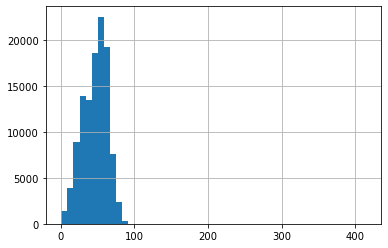

In [12]:
age_hist = all_xray_df['Patient Age'].hist(bins=50)

In [13]:
all_xray_df[all_xray_df['Patient Age'] > 100]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Class
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,1,0,Pneumonia
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,0,0,Non-pneumonia
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,...,0,0,0,0,1,0,0,0,0,Non-pneumonia
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,...,0,0,0,0,1,0,0,0,0,Non-pneumonia
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,...,0,0,1,1,0,0,0,0,0,Non-pneumonia
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,...,0,0,0,0,1,0,0,0,0,Non-pneumonia
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,...,0,0,0,0,0,0,0,0,1,Non-pneumonia
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,...,0,0,1,0,0,0,0,0,0,Non-pneumonia
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,...,0,0,0,0,1,0,0,0,0,Non-pneumonia
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,...,0,0,0,1,0,0,1,0,0,Non-pneumonia


In [14]:
# Number of patients with age more than 100

len(all_xray_df[all_xray_df['Patient Age'] > 100])

16

16 patients with age more than 148 which means these patients have wrong data entered for their age.

In [15]:
# drop patients with wrong ages
all_xray_df = all_xray_df[all_xray_df['Patient Age'] <= 100]

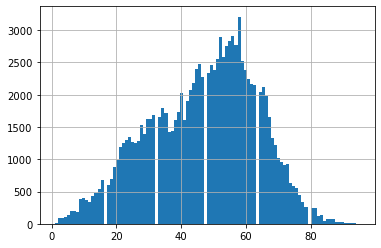

In [16]:
all_xray_df['Patient Age'].hist(bins=100)

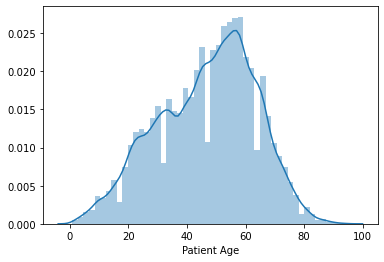

In [17]:
# age distribution for all patients
sns.distplot(all_xray_df['Patient Age']);

#### Age distribution for patients having Pneumonia

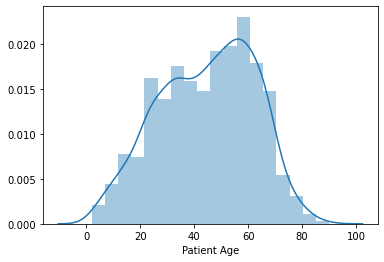

In [18]:
# age distribution for patients having Pneumonia
sns.distplot(all_xray_df.loc[all_xray_df.Pneumonia==1, 'Patient Age']);

## Gender

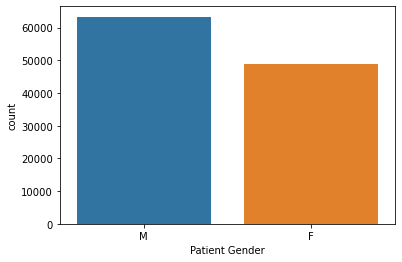

In [19]:
# Gender distribution
sns.countplot(data = all_xray_df, x = 'Patient Gender');

In [20]:
num_male = all_xray_df[all_xray_df['Patient Gender'] == 'M']
num_female = all_xray_df[all_xray_df['Patient Gender'] == 'F']
print(f'Gender distribution for complete population\nMale: {len(num_male)} ({100.0*len(num_male)/len(all_xray_df):.2f}%), \
Female: {len(num_female)} ({100.0*len(num_female)/len(all_xray_df):.2f}%)')

Gender distribution for complete population
Male: 63328 (56.49%), Female: 48776 (43.51%)


##### Gender distribution for Pneumonia patients

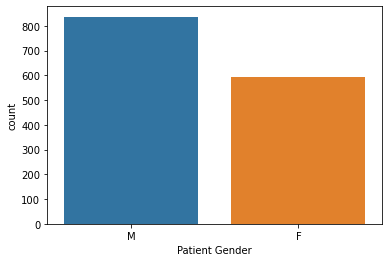

In [23]:
# Gender distribution for Pneumonia patients
sns.countplot(data = all_xray_df.loc[all_xray_df.Pneumonia==1], x = 'Patient Gender');

In [24]:
num_male_p = all_xray_df[(all_xray_df.Pneumonia==1) & (all_xray_df['Patient Gender'] == 'M')]
num_female_p = all_xray_df[(all_xray_df.Pneumonia==1) & (all_xray_df['Patient Gender'] == 'F')]
print(f'Gender distribution for Pneumonia patients\nMale: {len(num_male_p)} ({100.0*len(num_male_p)/len(all_xray_df[(all_xray_df.Pneumonia==1)]):.2f}%), \
Female: {len(num_female_p)} ({100.0*len(num_female_p)/len(all_xray_df[(all_xray_df.Pneumonia==1)]):.2f}%)')

Gender distribution for Pneumonia patients
Male: 837 (58.53%), Female: 593 (41.47%)


## View position

In [25]:
all_xray_df['View Position'].unique()

array(['PA', 'AP'], dtype=object)

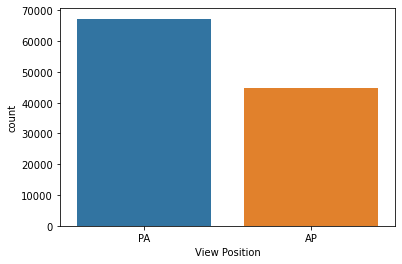

In [26]:
sns.countplot(data = all_xray_df, x = 'View Position');

In [27]:
pos_pa = all_xray_df[all_xray_df['View Position'] == 'PA']
pos_ap = all_xray_df[all_xray_df['View Position'] == 'AP']
print(f'View position value distribution\nPA: {len(pos_pa)} ({100.0*len(pos_pa)/len(all_xray_df):.2f}%),\
AP: {len(pos_ap)} ({100.0*len(pos_ap)/len(all_xray_df):.2f}%)')

View position value distribution
PA: 67299 (60.03%),AP: 44805 (39.97%)


## Other EDA

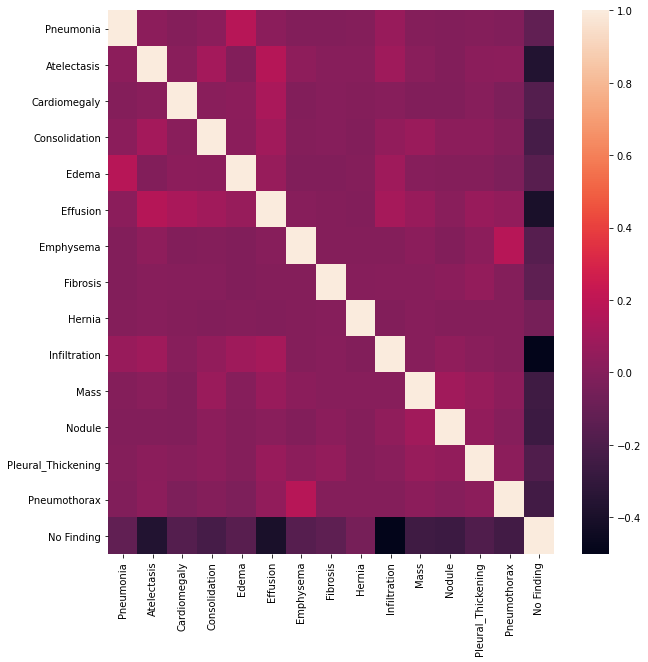

In [28]:
# distribution of other diseases that are comorbid with pneumonia
plt.figure(figsize=(10,10))
comorbid = ['Pneumonia', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumothorax', 'No Finding']
label_df = all_xray_df[comorbid]
corr_df = label_df.corr() 
sns.heatmap(corr_df);

Pneumonia has more correlation with Edema and Infiltration compared to other diseases

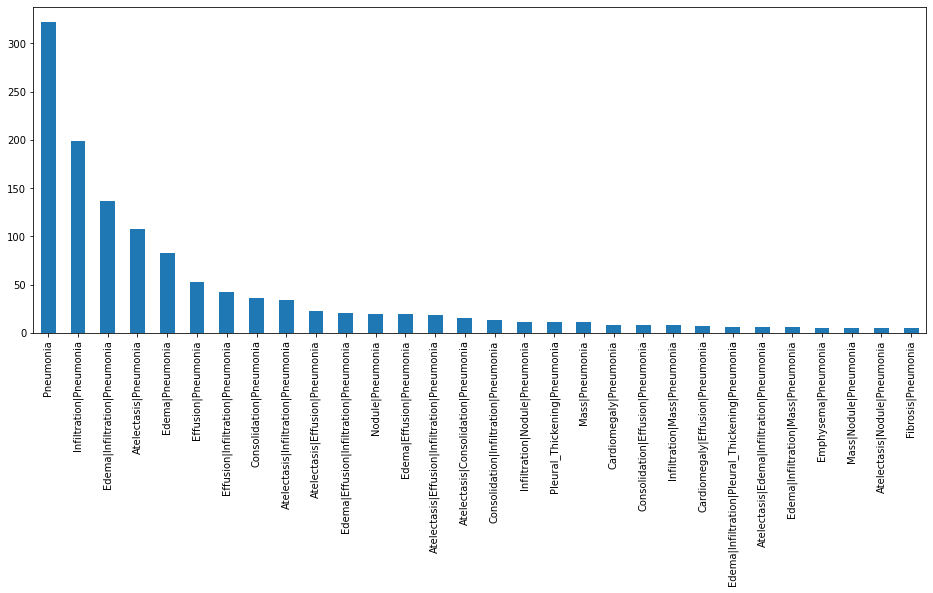

In [29]:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df['Pneumonia']==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar');

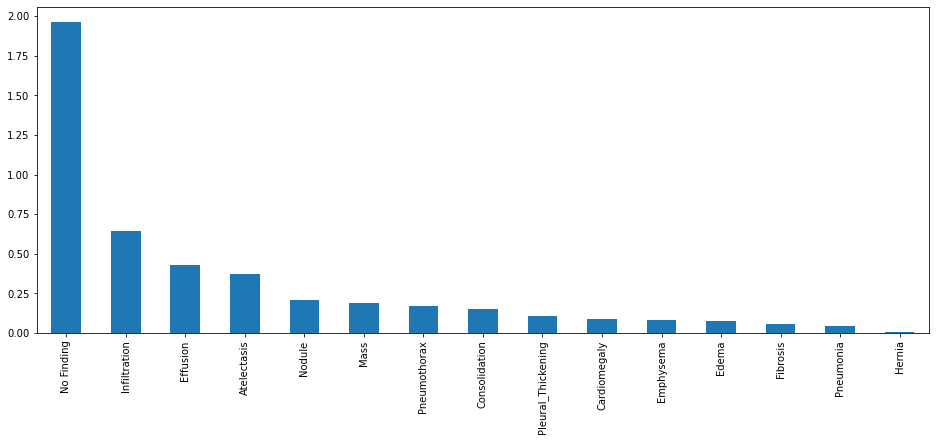

In [30]:
# number of disease per patient
plt.figure(figsize=(16,6))
(label_df.sum() / all_xray_df['Patient ID'].nunique()).sort_values(ascending=False).plot.bar();

# Pixel wise analysis

In [31]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
1325,00006952_006.png,No Finding,6,6952,030Y,M,AP,2048,2500,0.168,0.168
5189,00027725_073.png,Emphysema|Pneumonia|Pneumothorax,73,27725,021Y,M,AP,3056,2544,0.139,0.139
4287,00021170_003.png,No Finding,3,21170,035Y,F,AP,3028,2544,0.139,0.139


In [32]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5606 non-null   object 
 1   Finding Labels               5606 non-null   object 
 2   Follow-up #                  5606 non-null   int64  
 3   Patient ID                   5606 non-null   int64  
 4   Patient Age                  5606 non-null   object 
 5   Patient Gender               5606 non-null   object 
 6   View Position                5606 non-null   object 
 7   OriginalImageWidth           5606 non-null   int64  
 8   OriginalImageHeight          5606 non-null   int64  
 9   OriginalImagePixelSpacing_x  5606 non-null   float64
 10  OriginalImagePixelSpacing_y  5606 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 481.9+ KB


In [33]:
sample_df.describe()

,Follow-up #,Patient ID,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
count,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000
mean,8.616661,14330.617017,2644.795755,2491.087406,0.155467,0.155467
std,15.565815,8411.477789,347.188754,399.119063,0.016201,0.016201
min,0.000000,13.000000,1362.000000,966.000000,0.115000,0.115000
25%,0.000000,7289.000000,2500.000000,2048.000000,0.143000,0.143000
50%,3.000000,13993.000000,2542.000000,2544.000000,0.143000,0.143000
75%,10.000000,20655.500000,2992.000000,2991.000000,0.168000,0.168000
max,177.000000,30797.000000,3266.000000,3056.000000,0.198800,0.198800


In [34]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].apply(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [46]:
for label in all_labels:
    sample_df[label] = sample_df['Finding Labels'].map(lambda finding: 1 if label in finding else 0)

In [47]:
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
3047,00015031_029.png,No Finding,29,15031,040Y,F,AP,3052,2544,0.139,...,0,0,0,0,0,1,0,0,0,0
4198,00020630_009.png,No Finding,9,20630,030Y,M,PA,2720,2581,0.143,...,0,0,0,0,0,1,0,0,0,0
3214,00015818_001.png,Infiltration,1,15818,063Y,M,AP,2500,2048,0.168,...,0,0,0,1,0,0,0,0,0,0


In [48]:
image_name = sample_df[sample_df['Pneumonia']==1]['Image Index'].sample().item()

In [49]:
image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}


def image_distribution(img_data):
    f = plt.figure()
    f.set_figwidth(10)
    s1 = f.add_subplot(1, 2, 1)
    s1.set_title('Image')
    plt.imshow(img_data, cmap='gray')
    s2 = f.add_subplot(1, 2, 2)
    s2.set_title('Intensity Distribution')
    plt.hist(img_data.ravel(), bins = 256)
    plt.xlim((10,255))
    plt.ylim((0,15000))
    plt.show()



##### Samples of Pneumonia

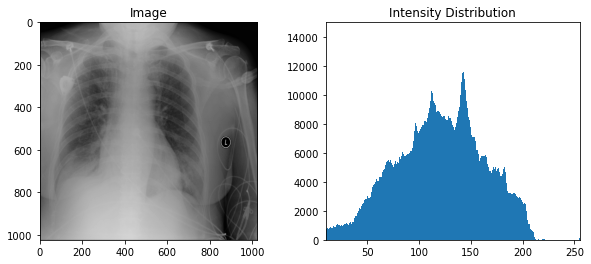

In [50]:
from skimage import io
img_data = io.imread(image_paths[image_name])
image_distribution(img_data)

Image Name 00004075_000.png


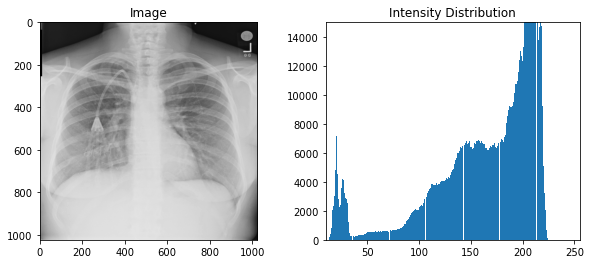

In [51]:
# some more Pneumonia images
image_name = sample_df[sample_df['Pneumonia']==1]['Image Index'].sample().item()
print('Image Name', image_name)
img_data = io.imread(image_paths[image_name])
image_distribution(img_data)

Image Name 00011251_010.png


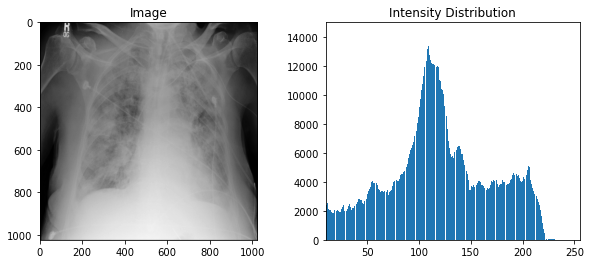

In [52]:
image_name = sample_df[sample_df['Pneumonia']==1]['Image Index'].sample().item()
print('Image Name', image_name)
img_data = io.imread(image_paths[image_name])
image_distribution(img_data)

Image Name 00011251_010.png


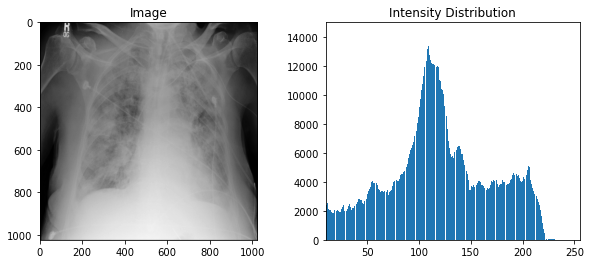

In [53]:
image_name = sample_df[sample_df['Pneumonia']==1]['Image Index'].sample().item()
print('Image Name', image_name)
img_data = io.imread(image_paths[image_name])
image_distribution(img_data)

Image Name 00019021_001.png


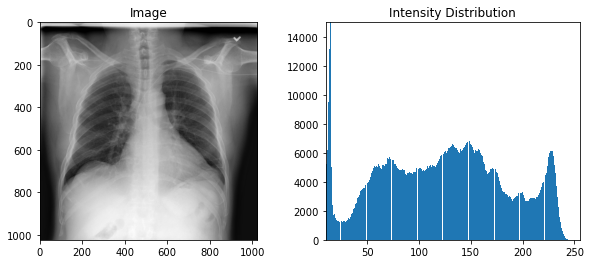

In [54]:
image_name = sample_df[sample_df['Pneumonia']==1]['Image Index'].sample().item()
print('Image Name', image_name)
img_data = io.imread(image_paths[image_name])
image_distribution(img_data)

Image Name 00008763_001.png


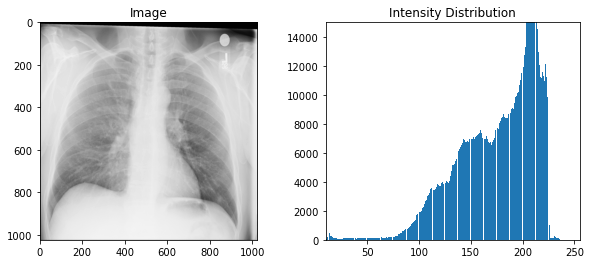

In [55]:
image_name = sample_df[sample_df['Pneumonia']==1]['Image Index'].sample().item()
print('Image Name', image_name)
img_data = io.imread(image_paths[image_name])
image_distribution(img_data)

Image Name 00019938_003.png


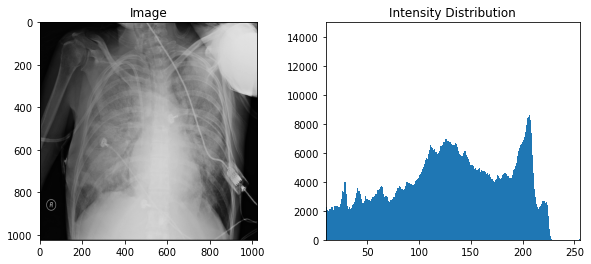

In [56]:
image_name = sample_df[sample_df['Pneumonia']==1]['Image Index'].sample().item()
print('Image Name', image_name)
img_data = io.imread(image_paths[image_name])
image_distribution(img_data)

##### Samples of no Pneumonia

Image Name 00028795_007.png


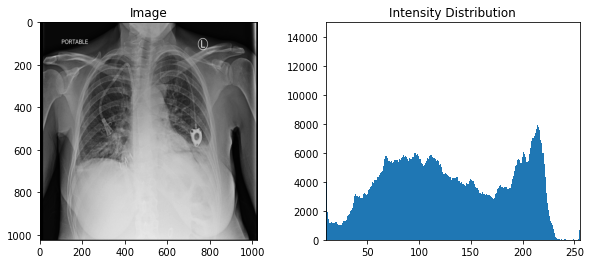

In [57]:
# Some more samples where there is no Pneumonia 
image_name = sample_df[sample_df['Pneumonia']==0]['Image Index'].sample().item()
print('Image Name', image_name)
img_data = io.imread(image_paths[image_name])
image_distribution(img_data)

Image Name 00005448_004.png


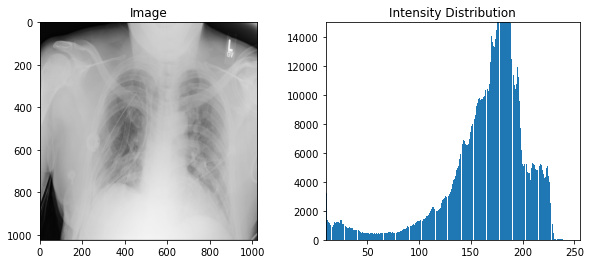

In [58]:
# Some more samples where there is no Pneumonia 
image_name = sample_df[sample_df['Pneumonia']==0]['Image Index'].sample().item()
print('Image Name', image_name)
img_data = io.imread(image_paths[image_name])
image_distribution(img_data)

Image Name 00027213_086.png


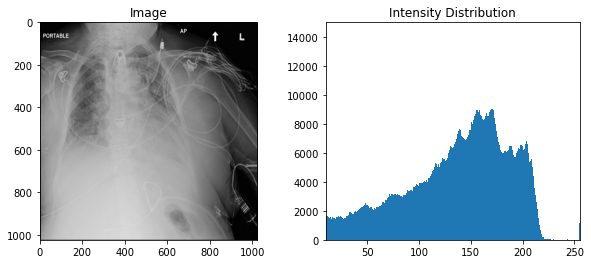

In [59]:
# Some more samples where there is no Pneumonia 
image_name = sample_df[sample_df['Pneumonia']==0]['Image Index'].sample().item()
print('Image Name', image_name)
img_data = io.imread(image_paths[image_name])
image_distribution(img_data)

Image Name 00020624_011.png


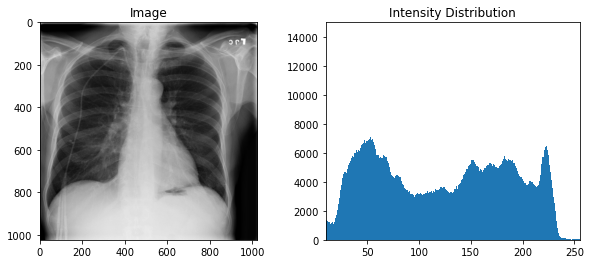

In [60]:
# Some more samples where there is no Pneumonia 
image_name = sample_df[sample_df['Pneumonia']==0]['Image Index'].sample().item()
print('Image Name', image_name)
img_data = io.imread(image_paths[image_name])
image_distribution(img_data)

###### Conclusion
For most of the Pneumonia samples, we see that the peak lies between 100-150. We are not considering around zero as those values are due to the background. We can also observe that the peak is not between this range. Most of these distributions resemble normal distribution. But we also see multiple spikes in these distributions which could be due to the presence of external entities.Several of these distributions doesn't seem to be continuous as we see some gaps at regular intervals. The erratic nature of some of these distributions could also be attributed to improper method in taking these images. In some of the images, patient is not properly facing the machineamd the resulting image is a bit disoriented.